<a href="https://colab.research.google.com/github/alimoorreza/cs195-fall24-notes/blob/main/cs195_object_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Object detection inference using the pre-trained Faster R-CNN model, which has been trained on the COCO dataset and can recognize 91 objects, including `person`, `dog`, and `cat`.**
- [Microsoft COCO (Common Object in COntext)](https://cocodataset.org/#explore)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/MyDrive/cs195_fall24/detection/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install cython

#**Please download the PennFudanPed dataset from Blackboard and upload it to your Google Drive.**
- [https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)
- I have uploaded the dataset on Blackboard as well; you could download it from there as well.
- Alternately, please execute the following lines or manually download this dataset and upload it to your Google Drive:
  - !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
  - !unzip PennFudanPed.zip

In [22]:
# my path goes as follows:

root = '/content/drive/MyDrive/cs195_fall24/detection/'

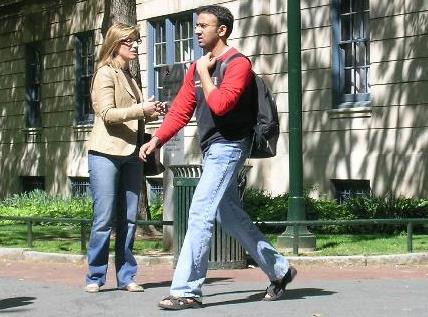

In [6]:
from PIL import Image
Image.open(root + 'PennFudanPed/PNGImages/PennPed00089.png')

boundding boxes: 
[[84, 24, 164, 293], [139, 5, 296, 308]]


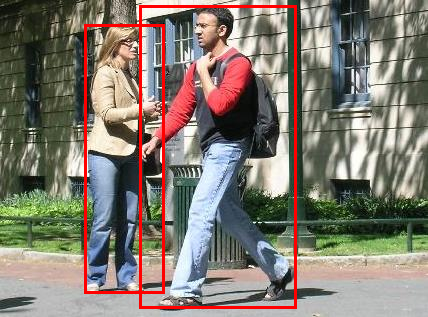

In [8]:
import numpy as np
from PIL import Image, ImageDraw
# visualization of bound-boxes associated with the objects (pedestrian)

mask = Image.open(root + 'PennFudanPed/PedMasks/PennPed00089_mask.png')
mask = np.array(mask)

# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

print(f"boundding boxes: \n{boxes}")

# draw the bounding boxes using PIL.ImageDraw, as we did in our in-class activity #1
rgb_image = Image.open(root + 'PennFudanPed/PNGImages/PennPed00089.png')
draw      = ImageDraw.Draw(rgb_image)

# draw rectangular bouding boxes on the image
for box in boxes:
    draw.rectangle(box, outline="red", width=3)

# show the image
rgb_image


In [9]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path    = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path   = os.path.join(self.root, "PedMasks", self.masks[idx])
        img         = Image.open(img_path).convert("RGB")
        mask        = Image.open(mask_path) # note that we haven't converted the mask to RGB because each color corresponds to a different instance with 0 being background



        mask        = np.array(mask)
        obj_ids     = np.unique(mask) # instances are encoded as different colors
        obj_ids     = obj_ids[1:]     # first id is the background, so remove it

        # split the color-encoded mask into a set of binary masks
        masks       = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs    = len(obj_ids)
        boxes       = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes       = torch.as_tensor(boxes, dtype=torch.float32)
        labels      = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
        masks       = torch.as_tensor(masks, dtype=torch.uint8)

        image_id    = torch.tensor([idx])
        #area        = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #iscrowd   = torch.zeros((num_objs,), dtype=torch.int64) # suppose all instances are not crowd

        target              = {}
        target["boxes"]     = boxes
        target["labels"]    = labels
        target["masks"]     = masks
        target["image_id"]  = image_id
        #target["area"]      = area
        #target["iscrowd"]   = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [11]:
# testing the Dataset class we just created
dataset = PennFudanDataset(root + 'PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0])})

In [12]:
%%shell
git clone https://github.com/alimoorreza/cs195_fall24_detection.git

cp cs195_fall24_detection/utils.py ./
cp cs195_fall24_detection/transforms.py ./
cp cs195_fall24_detection/coco_eval.py ./
cp cs195_fall24_detection/engine.py ./
cp cs195_fall24_detection/coco_utils.py ./

Cloning into 'cs195_fall24_detection'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 18.38 KiB | 9.19 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [13]:
from engine import train_one_epoch, evaluate
# if it fails to execute, then open coco_eval.py and comment out the statement: import torch._six
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or e

image shape is: (536, 559, 3)


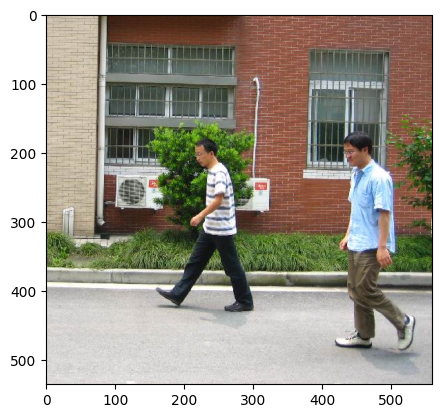

In [15]:
import matplotlib.pyplot as plt
import torchvision

# load the pre-trained Faster R-CNN model with a ResNet-50-FPN backbone
model           = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# load the dataset
dataset         = PennFudanDataset(root + 'PennFudanPed', get_transform(train=False))
data_loader     = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn
)

# retrieve the next batch of images for inference using the pre-trained Faster R-CNN model
images,targets  = next(iter(data_loader))
images          = list(image for image in images)
targets         = [{k: v for k, v in t.items()} for t in targets]

# visualize one of the images before running the inference
SELECTED_IMAGE_INDEX = 0 # Change it to one of the values: 0, 1, 2, or 3. This will display the results for different images.
img             = images[SELECTED_IMAGE_INDEX].numpy() # we have a batch of 4 images
img             = img.transpose(1, 2, 0)
print(f"image shape is: {img.shape}")
plt.imshow(img)

In [16]:
# By running only the inference through Faster R-CNN and invoking the .eval() method,
# we ensure that the model operates in inference mode rather than training mode.
model.eval()
predictions = model(images)
print(predictions)

[{'boxes': tensor([[419.6543, 170.1428, 535.9163, 493.5635],
        [159.0760, 180.3637, 298.8197, 434.4564],
        [439.7836, 222.6208, 452.0138, 271.8359],
        [444.3562, 224.4628, 456.1511, 265.5336],
        [437.7808, 226.5965, 446.2904, 271.2691]], grad_fn=<StackBackward0>), 'labels': tensor([ 1,  1, 32, 32, 32]), 'scores': tensor([0.9997, 0.9996, 0.5827, 0.2102, 0.0943], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[6.8278e+01, 9.1348e+01, 1.8817e+02, 3.8480e+02],
        [1.4569e+02, 9.5121e+01, 2.2644e+02, 3.7106e+02],
        [1.6712e+02, 1.4284e+02, 2.2709e+02, 2.4887e+02],
        [1.8791e+02, 1.6524e+02, 2.2514e+02, 2.4938e+02],
        [1.0082e-01, 0.0000e+00, 7.2657e+01, 1.9837e+02],
        [1.5086e+02, 9.0187e+01, 2.1105e+02, 2.8094e+02],
        [1.3899e+02, 1.1831e+02, 1.9344e+02, 3.7767e+02],
        [1.6500e+02, 1.2652e+02, 2.2639e+02, 2.4294e+02],
        [1.8784e+02, 1.6312e+02, 2.3018e+02, 2.4759e+02],
        [1.5689e+02, 1.2137e+02, 2.2770e+02, 2.4866e

In [17]:
# we downloaded the pre-trained Faster R-CNN model from the torchvision library,
# which has been trained on the following 91 categories of objects from the Microsoft COCO dataset

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

print(COCO_INSTANCE_CATEGORY_NAMES[1])

person


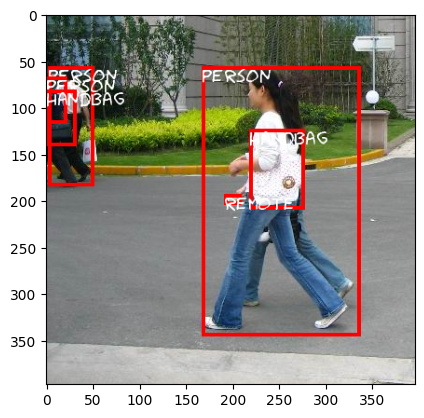

In [21]:
# visualization of bound-boxes associated with the objects (person)

import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
font = ImageFont.truetype("/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf", 20)

SELECTED_IMAGE_INDEX = 3 # Change it to one of the values 0, 1, 2, 3. It will display the result of different images

# draw the bounding boxes using PIL.ImageDraw, as we did in our in-class activity #1
rgb_image     = 255*images[SELECTED_IMAGE_INDEX].numpy() # after reading as PIL.Image, the array entries get values that range between [0-1]
rgb_image     = rgb_image.transpose(1, 2, 0)
rgb_image     = rgb_image.astype(np.uint8)
rgb_pil_img   = Image.fromarray(rgb_image)
rgb_pil_img   = rgb_pil_img.convert('RGB')
draw          = ImageDraw.Draw(rgb_pil_img)

# draw rectangular bouding boxes on the image
boxes         = predictions[SELECTED_IMAGE_INDEX]['boxes']
labels        = predictions[SELECTED_IMAGE_INDEX]['labels']
scores        = predictions[SELECTED_IMAGE_INDEX]['scores']

font_size     = 70

for i in range(len(boxes)):
    box         = boxes[i].detach().numpy()
    box         = box.astype(int)
    label_id    = labels[i]
    label_name  = COCO_INSTANCE_CATEGORY_NAMES[label_id]
    score       = scores[i]
    # print(f"bounding boxes: \n{box} for label={label_name}")

    # draw a rectangular bounding box on the image to display the detection result.
    if score > 0.5: # only display the detected objects with reliable predictions.

      draw.rectangle([box[0], box[1], box[2], box[3] ], outline="red", width=4)
      text_x_coord, text_y_coord = box[0], box[1]
      draw.text((text_x_coord, text_y_coord), label_name, font=font, fill=(255, 255, 255))


# show the image
plt.imshow(np.asarray(rgb_pil_img))

#**Group task#1**
> ### **Download a few random images from the internet (whichever ones you like) and try running inference with this pretrained Faster R-CNN model**

> Overlay the bounding boxes on the images, along with their predicted labels.

> Then, write down your observations—how accurate the detections were, how many objects were correctly identified, and how many were missed. Also, note if any objects were missed due to occlusion or other challenges.